### Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing all the important libraries

In [3]:
!pip install Augmentor

In [4]:
import pathlib
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
import Augmentor
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential

In [5]:
## Printing versions
print("TensorFlow version:", tf.__version__)
print("Keras version:", keras.__version__)
print("Matplotlib version:", matplotlib.__version__)
print("NumPy version:", np.__version__)
print("Pandas version:", pd.__version__)
print("PIL version:", PIL.__version__)
print("Augmentor version:", Augmentor.__version__)

TensorFlow version: 2.18.0
Keras version: 3.8.0
Matplotlib version: 3.8.0
NumPy version: 1.26.4
Pandas version: 2.1.4
PIL version: 10.2.0
Augmentor version: 0.2.12


In [6]:
## If you are using the data by mounting the google drive, use the following :
#from google.colab import drive
#drive.mount('/content/gdrive')


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [8]:
### Importing Skin Cancer Dataz
### Take necessary actions to read the data

In [9]:
## Defining the path for train and test images
## Paths of the train and test dataset
data_dir_train = pathlib.Path("Train\\")
data_dir_test = pathlib.Path('Test\\')

In [10]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

**Let's load these images off disk using the helpful image_dataset_from_directory utility.**

### Create a dataset

Define some parameters for the loader:

In [13]:
batch_size = 32
img_height = 180
img_width = 180

## Splitting into 80% as train dataset and 20% as test dataset
## Using seed=123 for creating dataset using tf.keras.preprocessing.image_dataset_from_directory
## Resizing images to the size img_height*img_width, while writting the dataset
train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="both",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

test_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir_test,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.
Using 447 files for validation.
Found 118 files belonging to 9 classes.


Use 80% of the images for training, and 20% for validation.

In [15]:
# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
### Create a code to visualize one instance of all the nine classes present in the dataset

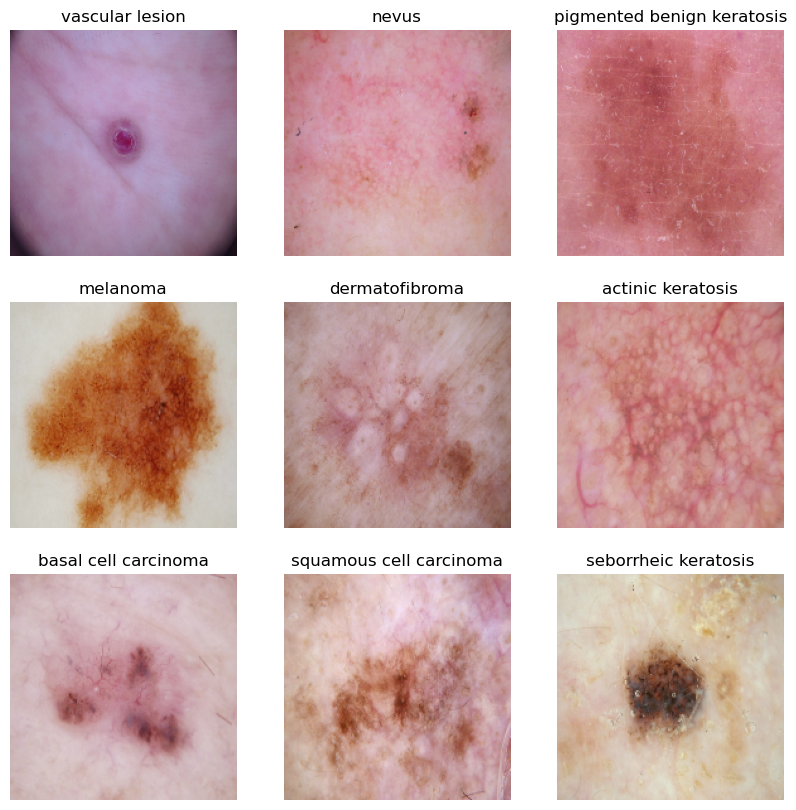

In [17]:
import tensorflow as tf
import matplotlib.pyplot as plt

### your code goes here, you can use training or validation data to visualize

plt.figure(figsize=(10, 10))

# Dictionary to track the first image of each class
class_images = {}

# Iterate over the dataset until we have one image per class
for images, labels in train_ds:
    for img, label in zip(images, labels):
        label = label.numpy()
        if label not in class_images:
            class_images[label] = img
        # Stop when all classes are found
        if len(class_images) == len(class_names):
            break
    if len(class_images) == len(class_names):
        break

# Plot the images
for i, (label, img) in enumerate(class_images.items()):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(img.numpy().astype("uint8"))
    plt.title(class_names[label])
    plt.axis("off")

plt.show()


In [18]:
for images, labels in train_ds.take(1):
    print("Images shape:", images.shape)
    print("Labels shape:", labels.shape)


Images shape: (32, 180, 180, 3)
Labels shape: (32,)


The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [21]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
### Create a CNN model, which can accurately detect 9 classes present in the dataset. Using ```layers.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [23]:
# Define the input shape
input_shape = (180, 180, 3)

# Create the model
model = models.Sequential([
    # Rescale pixel values
    layers.Rescaling(1./255, input_shape=input_shape),

    # First Convolutional Layer
    layers.Conv2D(32, (3, 3), activation='relu'),
    #layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    # Second Convolutional Layer
    layers.Conv2D(64, (3, 3), activation='relu'),
    #layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    # Third Convolutional Layer
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    # Flatten the output
    layers.Flatten(),

    # Fully Connected Layer
    layers.Dense(128, activation='relu'),

    # Output Layer with 9 classes
    layers.Dense(9, activation='softmax')
])

C:\Installed-Software\anaconda3\Lib\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


### Compile the model with an appropirate optimiser and loss function for model training

In [25]:
### Choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [26]:
# View the summary of all layers
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 178, 178, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 89, 89, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 87, 87, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 43, 43, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 41, 41, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 51200)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     6,553,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,648,137 (25.36 MB)

 Trainable params: 6,648,137 (25.36 MB)

 Non-trainable params: 0 (0.00 B)

### Train the model

In [28]:
# No of epochs
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 26s 388ms/step - accuracy: 0.2178 - loss: 2.3819 - val_accuracy: 0.3602 - val_loss: 1.7832
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 23s 404ms/step - accuracy: 0.3602 - loss: 1.7403 - val_accuracy: 0.4676 - val_loss: 1.5681
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 21s 366ms/step - accuracy: 0.4479 - loss: 1.6302 - val_accuracy: 0.4541 - val_loss: 1.5502
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 20s 363ms/step - accuracy: 0.4809 - loss: 1.4451 - val_accuracy: 0.5213 - val_loss: 1.4439
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 24s 435ms/step - accuracy: 0.5402 - loss: 1.3200 - val_accuracy: 0.5101 - val_loss: 1.4024
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 21s 373ms/step - accuracy: 0.5588 - loss: 1.2826 - val_accuracy: 0.5056 - val_loss: 1.4119
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 21s 372ms/step - accuracy: 0.5659 - loss: 1.2287 - val_accuracy: 0.4944 - val_loss: 1.4079
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 21s 384ms/step - accuracy: 0.5860 - loss: 1.2081 - val_accu

### Visualizing training results

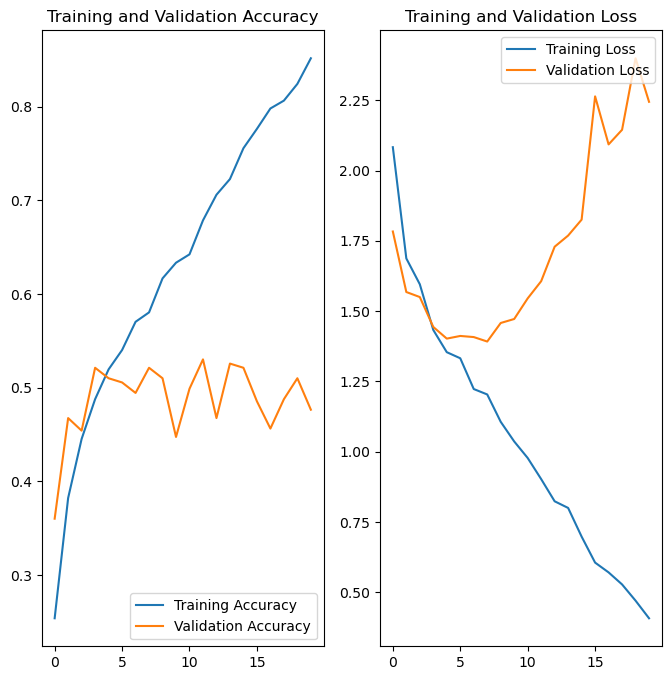

In [30]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Model is overfit
### The accuracy score on training data is way higher than the accuracy score on validation data which indicates overfitting of data. Also, the training and validation accuracy graph indicates the same, as the validation accuracy graph increases for sometime and then flattens , where as training accuracy continues to increase.  
### Similarly the loss graph indicates that the loss on validation set is more than the training set and the loss for training set is decreasing which means the model is learning on training set , but for the validation set it is increasing after a point which indicates overfitting.

### Write your findings here

In [33]:
# Model is overfit and hence using data augmentaion
# Data Augmentation
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
])

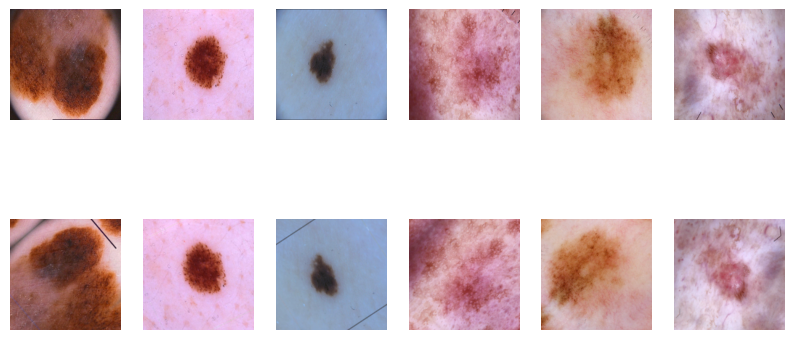

In [34]:
# Visualize the augmentation strategy works for one instance of training image.
# Get one batch
(image_batch, label_batch) = next(iter(train_ds.take(1)))
augmented_images = data_augmentation(image_batch)  # Apply augmentation

# Plot original and augmented images
plt.figure(figsize=(10, 5))
for i in range(6):
    plt.subplot(2, 6, i + 1)  # Top row for original
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    plt.axis("off")

    plt.subplot(2, 6, i + 7)  # Bottom row for augmented
    plt.imshow(augmented_images[i].numpy().astype("uint8"))
    plt.axis("off")

plt.show()

### Create the model, compile and train the model

In [36]:
## Using Data Augmentaion and Dropout layer as there is an evidence of overfitting.
## Trying only Dropout as L1 regularization along with Dropout reduced accuracy to a larger extent.

# Create the model
model2 = models.Sequential([
    # Data Augmentation
    data_augmentation,
    # Rescale pixel values
    layers.Rescaling(1./255, input_shape=input_shape),

    # First Convolutional Layer
    layers.Conv2D(32, (3, 3), activation='relu'),
   #layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    #layers.Dropout(0.25),

    # Second Convolutional Layer
    layers.Conv2D(64, (3, 3), activation='relu'),
   #layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    # Third Convolutional Layer
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    # Flatten the output
    layers.Flatten(),

    # Fully Connected Layer
    layers.Dense(128, activation='relu'),
    #layers.Dropout(0.45),

    # Output Layer with 9 classes
    layers.Dense(9, activation='softmax')
])



### Compiling the model

In [38]:
model2.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model2.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_1 (Sequential)       │ (32, 180, 180, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_1 (Rescaling)         │ (32, 180, 180, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (32, 178, 178, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (32, 89, 89, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (32, 87, 87, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (32, 43, 43, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (32, 43, 43, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (32, 41, 41, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (32, 20, 20, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (32, 20, 20, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (32, 51200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (32, 128)              │     6,553,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (32, 9)                │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,648,137 (25.36 MB)

 Trainable params: 6,648,137 (25.36 MB)

 Non-trainable params: 0 (0.00 B)

### Training the model

In [40]:
## Train model for 20 epochs
epochs = 20
history2 =model2.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 28s 440ms/step - accuracy: 0.2147 - loss: 2.4017 - val_accuracy: 0.3087 - val_loss: 1.8389
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 24s 437ms/step - accuracy: 0.3958 - loss: 1.6846 - val_accuracy: 0.4049 - val_loss: 1.6665
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 24s 421ms/step - accuracy: 0.4107 - loss: 1.6057 - val_accuracy: 0.4720 - val_loss: 1.5831
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 24s 436ms/step - accuracy: 0.4546 - loss: 1.5296 - val_accuracy: 0.5235 - val_loss: 1.4495
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 23s 418ms/step - accuracy: 0.4857 - loss: 1.4526 - val_accuracy: 0.5168 - val_loss: 1.4740
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 24s 437ms/step - accuracy: 0.5048 - loss: 1.3722 - val_accuracy: 0.5034 - val_loss: 1.4116
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 23s 410ms/step - accuracy: 0.5358 - loss: 1.3496 - val_accuracy: 0.5302 - val_loss: 1.3781
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 24s 427ms/step - accuracy: 0.5293 - loss: 1.3582 - val_accu

### Visualizing the results

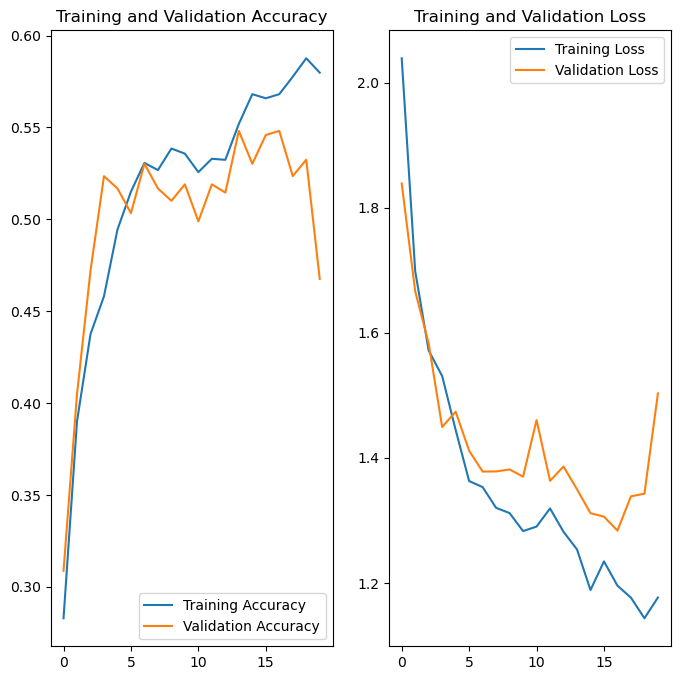

In [42]:
acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']

loss = history2.history['loss']
val_loss = history2.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### The difference between validation and training data set accuracy has reduced significantly compared to the previous model.

### No major overfitting. The training and validation accuracy curves are close to each other, and the loss curves also follow a similar trend, suggesting that the model is not overfitting significantly.

### The model is learning well and is not memorizing training data excessively.  The model is improving as training progresses since accuracy is increasing and loss is decreasing.

### Small fluctuations in validation loss could be due to a smaller dataset or some difficult-to-learn patterns. Slight fluctuations in validation accuracy and loss suggest some variance in validation performance, which could be due to data variability.

### The slightly higher validation loss and lower validation accuracy suggest that the model might benefit from more data.

### Find the distribution of classes in the training dataset.

### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

{'actinic keratosis': 0, 'basal cell carcinoma': 0, 'dermatofibroma': 0, 'melanoma': 0, 'nevus': 0, 'pigmented benign keratosis': 0, 'seborrheic keratosis': 0, 'squamous cell carcinoma': 0, 'vascular lesion': 0}
actinic keratosis: 92
basal cell carcinoma: 309
dermatofibroma: 77
melanoma: 352
nevus: 277
pigmented benign keratosis: 370
seborrheic keratosis: 58
squamous cell carcinoma: 142
vascular lesion: 115


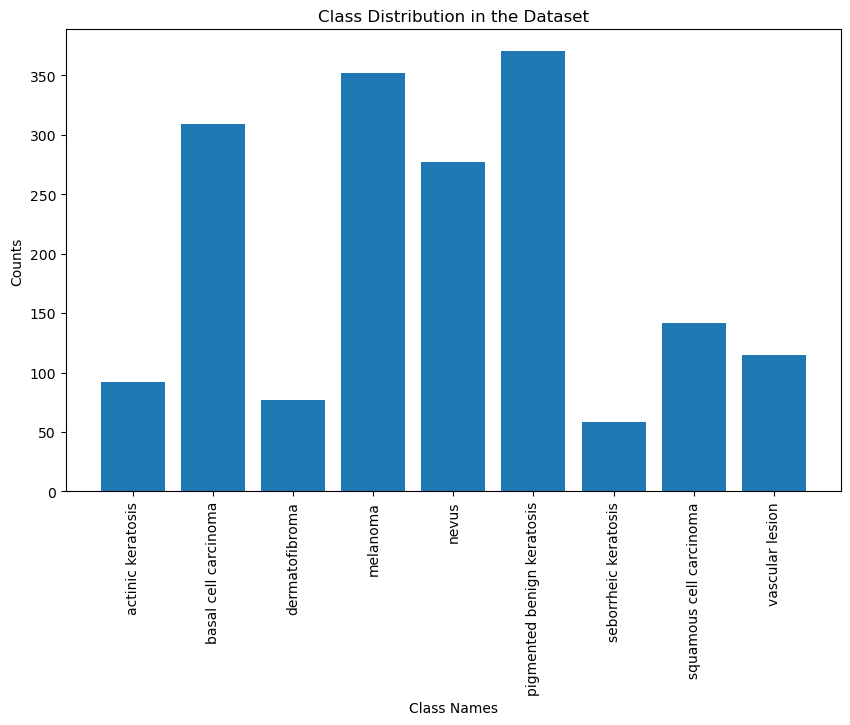

In [45]:
# Assuming train_ds is your dataset

class_counts = {class_name: 0 for class_name in class_names}
print(class_counts)
# Iterate through the dataset and count the occurrences of each class
for images, labels in train_ds:
    for label in labels:
        class_name = class_names[label.numpy()]
        class_counts[class_name] += 1

# Print the class distribution
for class_name, count in class_counts.items():
    print(f"{class_name}: {count}")

# Plot the class distribution
plt.figure(figsize=(10, 6))
plt.bar(class_counts.keys(), class_counts.values())
plt.xlabel('Class Names')
plt.ylabel('Counts')
plt.title('Class Distribution in the Dataset')
plt.xticks(rotation=90)
plt.show()


### - Which class has the least number of samples?

###   seborrheic keratosis: 58 . It has lesser samples in the training dataset.

### - Which classes dominate the data in terms proportionate number of samples?

###    The below 4 classes dominate the data in train dataset.
- basal cell carcinoma: 309
- melanoma: 352
- nevus: 277
- pigmented benign keratosis: 370


### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [48]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [50]:
path_to_training_dataset = pathlib.Path(data_dir_train)

import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(str(path_to_training_dataset / i))
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to Train\actinic keratosis\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x1FDCAE28C90>: 100%|██████████| 500/500 [00:05<00:00, 91.99 Samples/s] 


Initialised with 376 image(s) found.
Output directory set to Train\basal cell carcinoma\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x1FE35D0C610>: 100%|██████████| 500/500 [00:05<00:00, 87.04 Samples/s] 


Initialised with 95 image(s) found.
Output directory set to Train\dermatofibroma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1FDF0713090>: 100%|██████████| 500/500 [00:06<00:00, 79.03 Samples/s]                  


Initialised with 438 image(s) found.
Output directory set to Train\melanoma\output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x1FE35CDBA90>: 100%|██████████| 500/500 [00:28<00:00, 17.54 Samples/s]                   


Initialised with 357 image(s) found.
Output directory set to Train\nevus\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x1FE3604BD90>: 100%|██████████| 500/500 [00:27<00:00, 18.18 Samples/s] 


Initialised with 462 image(s) found.
Output directory set to Train\pigmented benign keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1FE35E72810>: 100%|██████████| 500/500 [00:06<00:00, 82.11 Samples/s]                   


Initialised with 77 image(s) found.
Output directory set to Train\seborrheic keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x1FE35F8CBD0>: 100%|██████████| 500/500 [00:14<00:00, 35.53 Samples/s]                  


Initialised with 181 image(s) found.
Output directory set to Train\squamous cell carcinoma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1FE35CE3190>: 100%|██████████| 500/500 [00:06<00:00, 81.30 Samples/s]                  


Initialised with 139 image(s) found.
Output directory set to Train\vascular lesion\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1FE35E8EB10>: 100%|██████████| 500/500 [00:06<00:00, 77.69 Samples/s]                  


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [52]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [54]:
import glob # import glob module
import os

path_list_new = [x for x in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
print(path_list_new[0])

Train\actinic keratosis\output\actinic keratosis_original_ISIC_0025780.jpg_774a8db2-29b5-490c-93a9-01f1af90908d.jpg


In [55]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new
print(lesion_list_new[0])

actinic keratosis


In [56]:
print(len(path_list_new), len(lesion_list_new))
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))


4500 4500


In [57]:
new_df = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
#new_df = original_df.append(df2)

In [58]:
new_df['Label'].value_counts()

Label
actinic keratosis             500
basal cell carcinoma          500
dermatofibroma                500
melanoma                      500
nevus                         500
pigmented benign keratosis    500
seborrheic keratosis          500
squamous cell carcinoma       500
vascular lesion               500
Name: count, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

### Train the model on the data created using Augmentor

In [61]:
batch_size = 32
img_height = 180
img_width = 180

### Create a training and validation dataset

In [63]:
#data_dir_train="path to directory with training data + data created using augmentor"
# We are using the same path where we have both augmented images in outputfolder and original images at level same as output folder
print(data_dir_train)
#data_dir_train = pathlib.Path("Train\\")

## Splitting into 80% as train dataset and 20% as test dataset
## Using seed=123 for creating dataset using tf.keras.preprocessing.image_dataset_from_directory
## Resizing images to the size img_height*img_width, while writting the dataset
train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="both",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Train
Found 6739 files belonging to 9 classes.
Using 5392 files for training.
Using 1347 files for validation.


### Create your model (make sure to include normalization)

In [65]:
# Define the input shape
input_shape = (180, 180, 3)

# Create the model
model3 = models.Sequential([
    # Data Augmentation
    data_augmentation,
    # Rescale pixel values
    layers.Rescaling(1./255, input_shape=input_shape),

    # First Convolutional Layer
    layers.Conv2D(32, (3, 3), activation='relu'),
   #layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    #layers.Dropout(0.15),

    # Second Convolutional Layer
    layers.Conv2D(64, (3, 3), activation='relu'),
   #layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    # Third Convolutional Layer
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    # Flatten the output
    layers.Flatten(),

    # Fully Connected Layer
    layers.Dense(128, activation='relu'),
    #layers.Dropout(0.15),

    # Output Layer with 9 classes
    layers.Dense(9, activation='softmax')
])



C:\Installed-Software\anaconda3\Lib\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


### Compile your model (Choose optimizer and loss function appropriately)

In [67]:
## your code goes here
## Your code goes here
model3.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model3.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_1 (Sequential)       │ (32, 180, 180, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_2 (Rescaling)         │ (32, 180, 180, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (32, 178, 178, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (32, 89, 89, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (32, 87, 87, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (32, 43, 43, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (32, 43, 43, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (32, 41, 41, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (32, 20, 20, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (32, 20, 20, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (32, 51200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (32, 128)              │     6,553,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (32, 9)                │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,648,137 (25.36 MB)

 Trainable params: 6,648,137 (25.36 MB)

 Non-trainable params: 0 (0.00 B)

### Train your model

In [69]:
## Train your model for 20 epochs as per evaluation rubric
epochs = 20
history3 = model3.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 83s 472ms/step - accuracy: 0.1664 - loss: 2.5106 - val_accuracy: 0.3318 - val_loss: 1.8684
Epoch 2/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 83s 493ms/step - accuracy: 0.3310 - loss: 1.8050 - val_accuracy: 0.4180 - val_loss: 1.5366
Epoch 3/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 80s 475ms/step - accuracy: 0.4211 - loss: 1.5282 - val_accuracy: 0.4439 - val_loss: 1.4647
Epoch 4/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 81s 481ms/step - accuracy: 0.4589 - loss: 1.4370 - val_accuracy: 0.4536 - val_loss: 1.4026
Epoch 5/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 81s 479ms/step - accuracy: 0.4709 - loss: 1.3922 - val_accuracy: 0.4529 - val_loss: 1.4369
Epoch 6/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 80s 475ms/step - accuracy: 0.4735 - loss: 1.3717 - val_accuracy: 0.4662 - val_loss: 1.3868
Epoch 7/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 80s 476ms/step - accuracy: 0.4932 - loss: 1.3209 - val_accuracy: 0.4491 - val_loss: 1.4474
Epoch 8/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 80s 470ms/step - accuracy: 0.5030 - loss: 1

### Visualize the model results

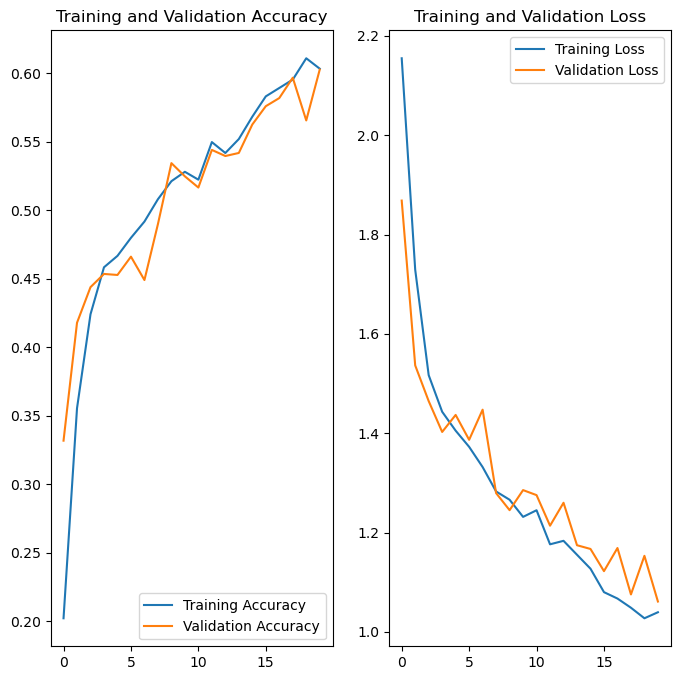

In [71]:
acc = history3.history['accuracy']
val_acc = history3.history['val_accuracy']

loss = history3.history['loss']
val_loss = history3.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?

## Comparison of Accuracy & Loss Graphs before and after class rebalance

## Before Rebalancing :

## a) Accuracy: The training and validation accuracy curves increase over epochs but show some fluctuation. The validation accuracy is slightly behind the training accuracy, indicating possible overfitting.

## b) Loss: The validation loss fluctuates more compared to the training loss. The difference between the two suggests that the model is not learning all classes equally well, likely due to class imbalance.

## After Rebalancing :

## a) Accuracy: The training and validation accuracy curves are more aligned, showing less fluctuation. This suggests improved generalization and better learning across all classes.

## b) Loss: The validation loss follows the training loss more closely, and both decrease more smoothly. This indicates that the model is learning more consistently across all classes.

## Which Model is Better?

## a) After rebalancing is better because, more stable validation accuracy (less fluctuation).
## b) Lower validation loss and better alignment with training loss.
## c) Better generalization (training and validation accuracy curves are closer).

## Conclusion:

## Rebalancing helped the model learn more effectively across all classes, reducing bias toward majority classes. This results in better overall model performance and less overfitting.

## Evaluate against the test set

In [75]:
normalization_layer = tf.keras.layers.Rescaling(1./255)
normalized_test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))

In [76]:
test_model2_loss, test_model2_acc = model2.evaluate(test_ds)
print("Model 2 without Reimbalance")
print(f"Test Accuracy: {test_model2_acc:.2f}, Test Loss: {test_model2_loss:.2f}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 284ms/step - accuracy: 0.2608 - loss: 2.4220
Model 2 without Reimbalance
Test Accuracy: 0.28, Test Loss: 2.37


In [77]:
test_model3_loss, test_model3_acc = model3.evaluate(test_ds)
print("Model 3 with Reimbalance")
print(f"Test Accuracy: {test_model3_acc:.2f}, Test Loss: {test_model3_loss:.2f}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 259ms/step - accuracy: 0.3854 - loss: 2.8557
Model 3 with Reimbalance
Test Accuracy: 0.40, Test Loss: 2.56


## The class rebalance model, model3(with rebalance) with the test dataset also works better than model2(without rebalance) as the accuracy is high and more generalized than model2